In [1]:
import numpy as np
import os
import sys
import torch
import pytorch3d

import matplotlib.pyplot as plt

import trimesh
from pytorch3d.io import load_objs_as_meshes, save_obj
import numpy as np
from tqdm.notebook import tqdm

#from src.cleansed_cube import Cube

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex,
)

from src.plot_image_grid import image_grid

In [34]:
import torch
import torch.nn  as nn


from src.operators import get_gaussian

from src.cleansed_cube import SourceCube, sides_dict
from src.discrete_laplacian import DiscreteLaplacian
from src.discrete_gaussian import DiscreteGaussian
from src.padding import pad_side

class SimpleCube(nn.Module):
    def __init__(self, n, kernel=5, sigma=1, clip_value = 0.1, start=-0.5, end=0.5):
        super(SimpleCube, self).__init__()        
        self.n = n
        self.kernel = kernel
        self.params = sides_dict(n)
        self.source = SourceCube(n, start, end)
        #self.gaussian = get_gaussian(kernel)
        self.gaussian = DiscreteGaussian(kernel, sigma=sigma, padding=False)
        self.laplacian = DiscreteLaplacian()          
        for p in self.params.values():            
            p.register_hook(lambda grad: torch.clamp(
                torch.nan_to_num(grad), -clip_value, clip_value))

    def make_vert(self):
        return torch.cat([p[0].reshape(3, -1).t()
                          for p in self.params.values()]) 

    def forward(self):
        ps = torch.cat([p for p in self.params.values()])        
        deform_verts = ps.permute(0, 2, 3, 1).reshape(-1, 3)        
        new_src_mesh = self.source(deform_verts)        
        laplacian = self.final_laplacian(new_src_mesh.vertices) 
        return new_src_mesh, laplacian # self.laplacian(ps)
    
    def final_laplacian(self, vert):
        side_names = ['front', 'right', 'back', 'left', 'top', 'down']
        sides = {}
        vertices = vert[0, :, :3].reshape(6, self.n, self.n, 3)
        for i, side_name in enumerate(side_names):
            sides[side_name] = vertices[i]
        res = 0
        for side_name in side_names:
            padded = pad_side(sides, side_name, self.kernel)
            padded = padded.permute(2, 0, 1)[None]
            res += self.laplacian(padded) * 1/6
        return res
    
    def smooth(self):
        sides = {}
        for side_name in self.params:
            grad = self.params[side_name].grad[0]
            sides[side_name] = grad.permute(1, 2, 0)
            
        for side_name in self.params:
            padded = pad_side(sides, side_name, self.kernel)
            padded = padded.permute(2, 0, 1)[None]
            padded = self.gaussian(padded)
            self.params[side_name].grad.copy_(padded)
    
    def laplacian_loss(self):
        sides, loss = {}, 0
        for side_name in self.params:
            side = self.params[side_name]    
            sides[side_name] = side[0].permute(1, 2, 0)

        for side_name in self.params:
            padded = pad_side(sides, side_name, self.kernel)    
            padded = padded.permute(2, 0, 1)[None]
            loss += self.laplacian(padded) * 1/6
            
        return loss
      
    def export(self, f):        
        mesh, _ = self.forward()
        vertices = mesh.vertices[0].cpu().detach()
        faces = mesh.faces.cpu().detach()        
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
        mesh.export(f)


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


obj_filename = "./data/bunny.obj"
obj_filename = "./data/nefertiti.obj"
bunny = load_objs_as_meshes([obj_filename], device=device)

textures=TexturesVertex(verts_features=[torch.ones_like(bunny.verts_packed())])

bunny = Meshes(verts=[bunny.verts_packed()], 
           faces=[bunny.faces_packed()],
           textures=textures)

verts = bunny.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
bunny.offset_verts_(-center)
bunny.scale_verts_((1.0 / float(scale)));

In [4]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 32

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...])

bunnies = bunny.extend(num_views)

In [5]:
target_cameras = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]

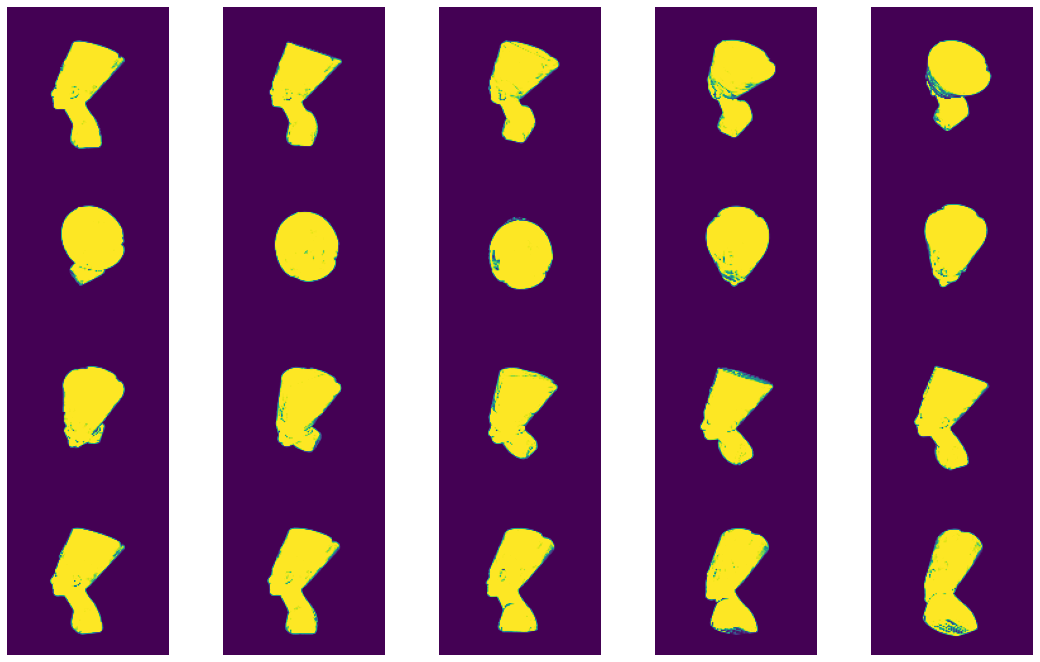

In [6]:
# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=128, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=150, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

# Render silhouette images.  The 3rd channel of the rendering output is 
# the alpha/silhouette channel
silhouette_images = renderer_silhouette(bunnies, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

In [7]:
silhouette_images.shape

torch.Size([32, 128, 128, 4])

In [37]:
n, kernel, sigma = 2, 3, 1

cube = SimpleCube(n, kernel=kernel, sigma=sigma, clip_value = 1.).to(device)

# self.gaussian(p.data.grad)

# clip_value = 0.1
# for p in cube.params.values():
#     #print(p)
#     p.register_hook(lambda grad: print(grad.shape) or torch.clamp(grad, -clip_value, clip_value))
#cube.export(f'./data/cube_mesh{n}.obj')
optimizer = torch.optim.SGD(cube.parameters(), lr=0.0001, momentum=0.)
#optimizer = torch.optim.Adam(cube.parameters(), lr=0.001)
optimizer

3


SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.0
    nesterov: False
    weight_decay: 0
)

In [38]:
Niter = 100000
num_views_per_iteration = 2

loop = tqdm(range(Niter))

laplace_weight =  1.

for i in loop:
    stop = False
#    with torch.autograd.detect_anomaly():
    optimizer.zero_grad()

    # Deform the mesh
    #new_src_mesh = src_mesh.offset_verts(torch.sigmoid(deform_verts))
    new_src_mesh, laplace_loss = cube.forward()
    #padded_laplacian = cube.laplacian_loss()
    #print(laplace_loss.item(), padded_laplacian.item())
    verts=new_src_mesh.vertices[:, :, :3]
    textures = TexturesVertex(verts_features=torch.ones_like(verts))
    p3d_mesh = Meshes(verts=verts,
                  faces=new_src_mesh.faces[None],
                  textures=textures)
    
    #laplacian_smoothing = mesh_laplacian_smoothing(new_src_mesh, method="uniform")
    sum_loss = torch.tensor(0.0, device=device) + laplace_loss * laplace_weight
    #print(laplace_loss.item(), laplacian_smoothing.item())
#     sum_loss += mesh_edge_loss(new_src_mesh) * 1.0
#     sum_loss += mesh_normal_consistency(new_src_mesh) * 0.01
#     sum_loss += mesh_laplacian_smoothing(new_src_mesh, method="uniform") * 1.0
    
    # Compute the average silhouette loss over two random views, as the average 
    # squared L2 distance between the predicted silhouette and the target 
    # silhouette from our dataset
    
    if False:
        for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
            images_predicted = renderer_silhouette(p3d_mesh, cameras=target_cameras[j], lights=lights)
            predicted_silhouette = images_predicted[..., 3]
            loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
            if not torch.isnan(loss_silhouette):            
                sum_loss += loss_silhouette / num_views_per_iteration            
            else:
                print('singularity', i)
                #for p in cube.params.values():
                #    torch.nan_to_num_(p.data)
                stop = True

        if stop:
            print(i)
            cube.export(f'./data/cube_mesh_{n}_{i}.obj')
    #         pytorch3d.io.save_ply(f'./data/deformed{i}.ply', 
    #             new_src_mesh.verts_packed(),
    #             faces=new_src_mesh.faces_packed())
            break
        
    loop.set_description("total_loss = %.6f" % sum_loss)
    if sum_loss > 0:
        sum_loss.backward()
        #cube.smooth()
        optimizer.step()
    
    if i % 500 == 0:
        f = f'./data/cube_mesh_{n}_{i}.obj'
        cube.export(f)
        print(f)
#kernel = 0
f = f'./data/cube_mesh_{n}_{kernel}.obj'
cube.export(f)
f

./data/cube_mesh_2_0.obj
./data/cube_mesh_2_500.obj
./data/cube_mesh_2_1000.obj
./data/cube_mesh_2_1500.obj
./data/cube_mesh_2_2000.obj
./data/cube_mesh_2_2500.obj
./data/cube_mesh_2_3000.obj
./data/cube_mesh_2_3500.obj
./data/cube_mesh_2_4000.obj
./data/cube_mesh_2_4500.obj
./data/cube_mesh_2_5000.obj
./data/cube_mesh_2_5500.obj
./data/cube_mesh_2_6000.obj
./data/cube_mesh_2_6500.obj



KeyboardInterrupt: 

In [17]:
vert = new_src_mesh.vertices
vert.shape

torch.Size([1, 96, 4])

In [21]:
vert[0, :, :3].reshape(6, 4, 4, 3).shape

torch.Size([6, 4, 4, 3])

In [24]:
side_names = ['front', 'right', 'back', 'left', 'top', 'down']
sides = {}
vertices = vert[0, :, :3].reshape(6, 4, 4, 3)
for i, side_name in enumerate(side_names):
    sides[side_name] = vertices[i]
sides['front'].shape

torch.Size([4, 4, 3])

In [25]:
pad_side(sides, 'front', 3).shape

torch.Size([6, 6, 3])

In [17]:
new_src_mesh, laplace_loss = cube.forward()

In [19]:
laplace_loss

tensor(3.8056, device='cuda:0', grad_fn=<AddBackward0>)